In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm as tqdm
import pdb
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from IPython.display import clear_output

path_to_data = '../Inputs-Targets.csv'

In [2]:
class WeatherDataset(Dataset):
    def __init__(self, csv_file, seq_length=8, train=True):
        # Make 80/20 test training split, preserving order
        self.data = pd.read_csv(csv_file)
        self.seq_length = seq_length
        self.train = train
        if train:
            self.data = self.data.iloc[:int(len(self.data)*0.8)]
        else:   
            self.data = self.data.iloc[int(len(self.data)*0.8):]

    def __len__(self):
        return (len(self.data)-self.seq_length)

    def __getitem__(self, i):
        # x is a tensor of shape (seq_length, 68)
        x = torch.tensor([self.data.iloc[j][1:69] for j in range(i, i+self.seq_length)]).to(torch.float64)
        y = torch.tensor(self.data.iloc[i+self.seq_length-1][69:72]).to(torch.float64)
        # print ('y: {}'.format(y))
        # print ('x_last: {}'.format(x[-1:]))
        # print (self.data.iloc[i+self.seq_length-1])
        return x, y

In [3]:
# Test dataset class

# t_data = WeatherDataset(path_to_data)
# t_dataloader = DataLoader(t_data, batch_size=4, shuffle=False)
# for batch in t_dataloader:
#     x, y = batch
#     print(x.shape)
#     print(y.shape)
#     break

In [4]:
class WeatherGRU(nn.Module):
    def __init__(self, input_size=68, hidden_size=256, output_size=3, n_layers=1, seq_length=8):
        super(WeatherGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=n_layers, dtype=torch.float64)
        self.out = nn.Linear(hidden_size, output_size, dtype=torch.float64)

    def forward(self, x_sequence):
        # for row in x_sequence, run forward step and update hidden
        for i in range(x_sequence.shape[1]):
            if i == 0:
                x, hidden = self.forward_step(x_sequence[:, i, :].unsqueeze(1), None)
            else:
                x, hidden = self.forward_step(x_sequence[:, i, :].unsqueeze(1), hidden)
        return x
        # x, _ = self.gru(x)
        # x = x[-1, :]
        # # x = x[:, -1, :]
        # return self.out(x)
    
    def forward_step(self, x, hidden):
        x, hidden = self.gru(x, hidden)
        x = x[:, -1, :]
        x = self.out(x)
        return x, hidden

In [5]:
def cache_session(model, path='model.pt', stat_dict={}):
    torch.save(model.state_dict(), path)
    torch.save(stat_dict, 'stat_dict.pt')


def restore_session(model, model_path='model.pt', stat_dict_path='stat_dict.pt'):
   # Restore model and stats from cache if available, else initialize new model and stats
    try:
        model.load_state_dict(torch.load(model_path))
        stat_dict = torch.load(stat_dict_path)
        losses = stat_dict['losses']
        window_losses = stat_dict['window_losses']
        val_losses = stat_dict['val_losses']
        epoch_num = stat_dict['epoch_num']
        print('Restored session from cache at epoch {}'.format(epoch_num))
    except:
        losses = []
        window_losses = []
        val_losses = []
        epoch_num = 0
        print('Unable to restore. Initialized new model and new session')
    return model, epoch_num, losses, window_losses, val_losses

def plot_loss(losses, loss_indices):
  for i, l in enumerate(losses):
    loss_label = l[0]
    loss_x = loss_indices[i]
    loss_y = l[1]
    plt.plot(loss_x, loss_y, label=loss_label)
  plt.legend()
  plt.ylabel('Loss')
  plt.xlabel('Batches')
  plt.show()

In [6]:
BATCH_SIZE = 4

# Make train and test datasets
train_data = WeatherDataset(path_to_data, train=True)
test_data = WeatherDataset(path_to_data, train=False)
# Initialize dataloaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 0/10901 [00:00<?, ?it/s]

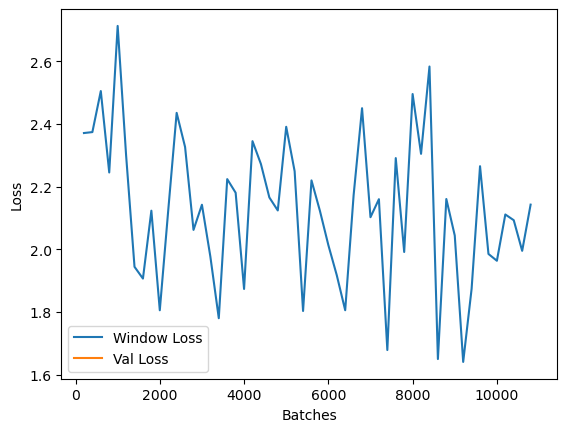

KeyboardInterrupt: 

In [9]:
UPDATE_STATUS_EVERY = 200

# Train model
def train(epochs, model, epoch_num=0, losses_tuple=([], []), window_losses_tuple=([], []), val_losses_tuple=([], [])):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    if window_losses_tuple[0] == []:
      total_batch_index = 0
    else:
      total_batch_index = window_losses_tuple[0][-1] + 1
    
    loss_indices = losses_tuple[0]
    losses = losses_tuple[1]
    window_loss_indices = window_losses_tuple[0]
    window_losses = window_losses_tuple[1]
    val_loss_indices = val_losses_tuple[0]
    val_losses = val_losses_tuple[1]

    # epochs_bar = tqdm(range(epochs), leave=False, position=epoch_num)

    for epoch in range(epoch_num, epochs):
        
        # Reset output for current epoch
        clear_output(wait=True)
        epochs_bar = tqdm(range(epochs), leave=False, initial=epoch) # Reset epochs bar
        try:
            epochs_bar.set_description(f'Epoch {epoch + 1}, Train Loss: {f"{recent_avg_loss:.3f}"}, Val Loss: {f"{avg_val_batch_loss:.3f}"}')
        except:
            epochs_bar.set_description(f'Epoch {epoch_num + 1}, Train Loss: N/A, Val Loss: N/A')

        batches_bar = tqdm(train_dataloader, leave=False)
        plot_loss(losses=(('Window Loss', window_losses), ('Val Loss', val_losses)),
                   loss_indices=(window_loss_indices, val_loss_indices)) # Plot current losses

        for batch in train_dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_indices.append(total_batch_index)
            losses.append(loss.item())
            batches_bar.update()
            total_batch_index += 1

            # Update batch bar periodically during batch
            if batches_bar.n % UPDATE_STATUS_EVERY == 0:
                recent_avg_loss = sum(losses[-UPDATE_STATUS_EVERY:])/UPDATE_STATUS_EVERY
                window_loss_indices.append(total_batch_index)
                window_losses.append(recent_avg_loss)
                batches_bar.set_description(f'Epoch {epoch + 1}, Train Loss: {f"{recent_avg_loss:.3f}"}')

        # Validate every epoch
        val_batches_bar = tqdm(test_dataloader, leave=False)
        val_batches_bar.set_description(f'Validating...')
        val_batches_bar.update()
        val_batch_losses = []
        model.eval()
        for batch in test_dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_batch_losses.append(loss.item())
            val_batches_bar.update()
        avg_val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
        val_loss_indices.append(total_batch_index)
        val_losses.append(avg_val_batch_loss)
        model.train()

        # Save model and losses
        stat_dict = {'epoch_num': epoch + 1,'losses': (loss_indices, losses), 'window_losses': (window_loss_indices, window_losses), 'val_losses': (val_loss_indices, val_losses)}
        cache_session(model ,stat_dict=stat_dict)

        # Update epoch bar
        epochs_bar.update()

model = WeatherGRU()
# model = Res50Model()
EPOCHS = 100
do_restore = True
if do_restore:
    train(EPOCHS, *restore_session(model))
else:
    print('Initialized new model and new session')
    train(EPOCHS, model)